## Clustering of homes.
Read
https://scikit-learn.org/stable/modules/clustering.html#optics

https://en.wikipedia.org/wiki/OPTICS_algorithm


In [1]:
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, cluster_optics_dbscan


In [2]:

# A sample of buildings, assumed to be buildings to place in ONE distribution grid

# TODO Check you have the datafile in the write place
#buildings = 'SmallSample_OSMbuildings.geojson'
buildings = 'SLE_KenemaRadius_OSMBuildings.geojson'
print('Loading data...')
# Prepare building data - read as geodataframe
gdf = gp.read_file(buildings)
# Get the number of rows (points) in the GeoDataFrame
#no_points = gdf.shape[0]
print(gdf.head())
gdf.to_file('buildigs.shp')
print(f"CRS is {gdf.crs}.") #CRF: Cooordinate Reference System

gdfm=gdf.to_crs(epsg=32628) # See https://epsg.io/32628
print(gdfm.head())
print(f"CRS is {gdfm.crs}.")
gdf = gdfm

Loading data...
      osm_id  code    fclass  name  type  \
0  194636169  1500  building  None  None   
1  194636173  1500  building  None  None   
2  194636191  1500  building  None  None   
3  194636195  1500  building  None  None   
4  194636203  1500  building  None  None   

                                            geometry  
0  MULTIPOLYGON (((-11.36684 7.99306, -11.36680 7...  
1  MULTIPOLYGON (((-11.36671 7.99309, -11.36670 7...  
2  MULTIPOLYGON (((-11.36670 7.99296, -11.36668 7...  
3  MULTIPOLYGON (((-11.36686 7.99279, -11.36679 7...  
4  MULTIPOLYGON (((-11.36661 7.99295, -11.36657 7...  
CRS is EPSG:4326.
      osm_id  code    fclass  name  type  \
0  194636169  1500  building  None  None   
1  194636173  1500  building  None  None   
2  194636191  1500  building  None  None   
3  194636195  1500  building  None  None   
4  194636203  1500  building  None  None   

                                            geometry  
0  MULTIPOLYGON (((900638.291 885298.644, 900642...

In [3]:
# Get centroid points of building polygons

gdf['centroid'] = gdf['geometry'].centroid
# Break out lat and long into separate columns of GeoDataFrame
gdf['lon'] = gdf.centroid.x
gdf['lat'] = gdf.centroid.y
# Get lat and long columns from the GeoDataFrame and convert into a numpy array
coords = gdf.drop(['name', 'type', 'code', 'fclass', 'osm_id', 'geometry', 'centroid'], axis=1).to_numpy()
# You will get a warning.

(846527.9035151711, 895503.7871979317)

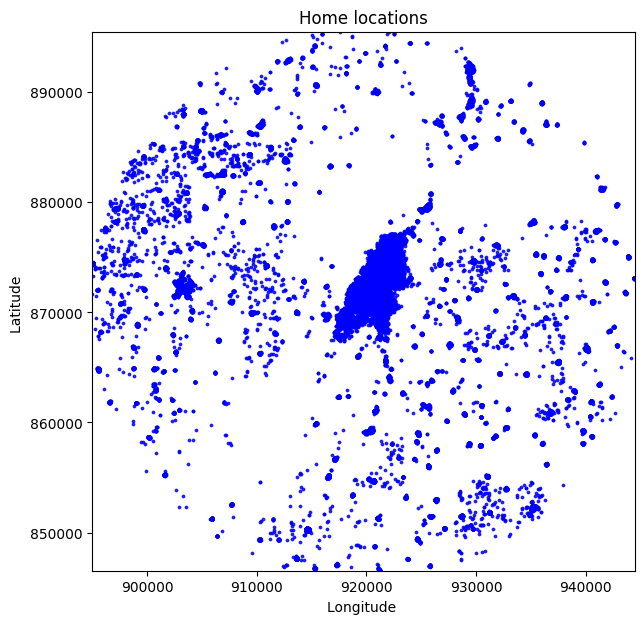

In [4]:
# Plot home locations
plt.figure(figsize=(7, 7))
plt.title('Home locations')
plt.scatter(x=coords[:, 0], y=coords[:, 1],color='b', s=3, alpha=0.8)
plt.xlabel('Longitude ')
plt.ylabel('Latitude ')
axes = plt.gca()
axes.set_xlim([min(coords[:, 0]) - 0.001, max(coords[:, 0]) + 0.001])
axes.set_ylim([min(coords[:, 1]) - 0.001, max(coords[:, 1]) + 0.001])


In [5]:
# Cluster the data
# TODO See how the parameters affect the result.

clust = OPTICS(min_samples=10, xi=.05, min_cluster_size=.5)

# Run the fit
clust.fit(coords)
labelsOp = clust.labels_

# See how many houses in each cluster. cluster -1 = outlier
(unique, counts) = np.unique(labelsOp, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   -1 21851]
 [    0 21899]]


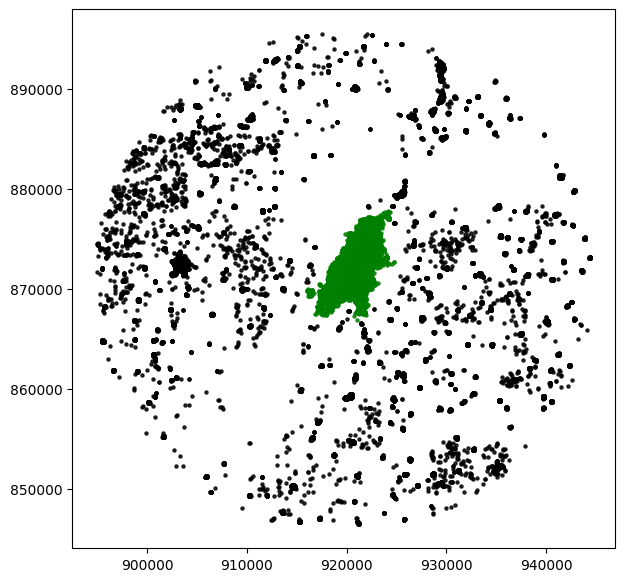

In [6]:


#plot results
plt.figure(figsize=(7, 7))

colors = ['g', 'r', 'b', 'y', 'c','m','olive','b','m']*20
labels = labelsOp
for klass, color in zip(range(0, 8), colors):
    plt.scatter(x=coords[labels == klass, 0], y=coords[labels == klass, 1],color=color, s=5, alpha=0.8)

# plot outliers
plt.scatter(x=coords[labels == -1, 0], y=coords[labels == -1, 1],color='k', s=5, alpha=0.8)

In [9]:
# TODO Now change range by changing eps in the DBSCAN equivalent.

labelsF = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=1000.0)

# See how many houses in each cluster. -1 = outlier
(unique, counts) = np.unique(labelsF, return_counts=True)
frequencies = np.asarray((unique, counts)).T

numClusters = unique.size
print(f"There are {numClusters} clusters")
# print(frequencies)

There are 144 clusters


In [10]:
print(f"There are {len(cluster_to_points.keys())} unique clusters")
print(cluster_to_points[0])



NameError: name 'cluster_to_points' is not defined

labelsF
 [ 0  0  0 ...  1  1 61] (43750,)
Cluster 0 with color g


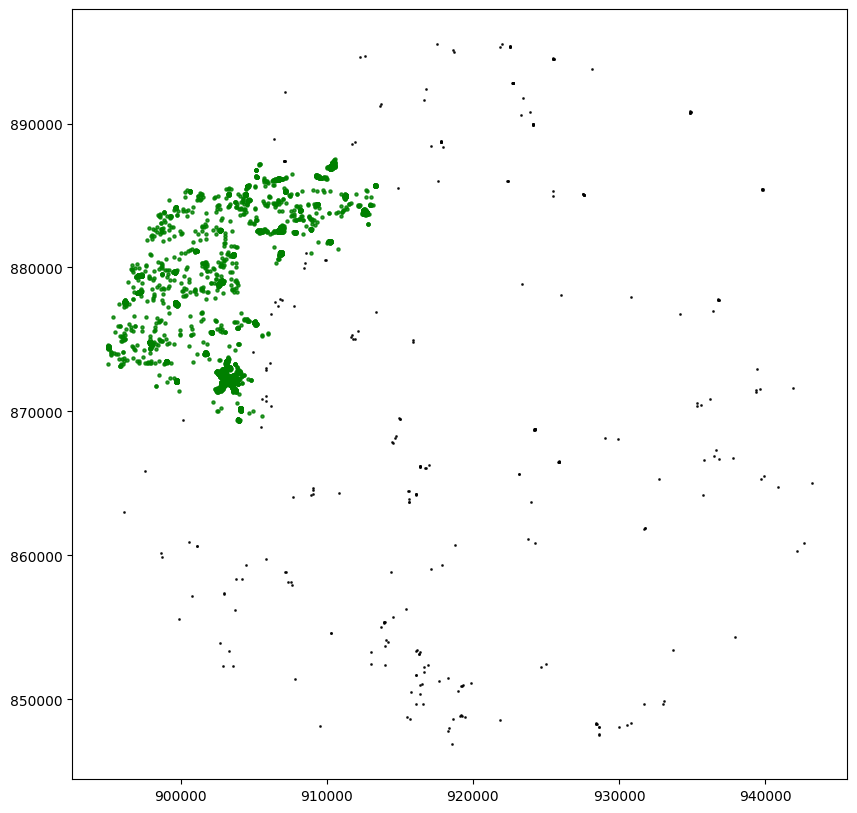

In [11]:
plt.figure(figsize=(10, 10))

numRepeats = int(numClusters/7+2)
colors = ['g', 'r', 'b', 'y','m', 'c','m','olive']*numRepeats
labels = labelsF



cluster_to_points = {}
for (point_index, cluster_assignment) in enumerate(labels):
    if cluster_assignment not in cluster_to_points:
        cluster_to_points[cluster_assignment] = [coords[point_index]]
    else:
        cluster_to_points[cluster_assignment].append(coords[point_index])



# plot outliers
plt.scatter(x=coords[labels == -1, 0], y=coords[labels == -1, 1],color='k', s=1, alpha=0.8)
print("labelsF\n",labelsF, np.shape(labelsF))
for klass, color in zip(range(0, numClusters), colors):
    print(f"Cluster {klass} with color {color}")
    plt.scatter(x=coords[labels == klass, 0], y=coords[labels == klass, 1],color=color, s=5, alpha=0.8)
    break



In [12]:
from scipy.spatial import Delaunay
import pandas as pd

In [13]:
# Haversine formula for kilometer distance between two lat/long points
def euclidean_distance(point1, point2):
    (x1, y1) = point1
    (x2, y2) = point2
    distance = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return distance

In [14]:
cluster_to_work_with = 1
coords = cluster_to_points[cluster_to_work_with]
no_points = len(coords)

print('Calculating Delaunay triangulation and distance between Delaunay neighbours...')
# Get Delauney triangulation of coordinates
tri = Delaunay(coords)
indices = tri.vertex_neighbor_vertices[0]
indptr = tri.vertex_neighbor_vertices[1]

# Instantiate dictionary to hold neighbors of each point & data-frame to hold distances between neighbours
neighbors = {}
locations = {}
distances = pd.DataFrame(columns=["source", "dest", "distance"])
 

# Get dictionary of neighbors of all points and a dictionary of locations of all points
for k in range(0, no_points):
    neighbors[k] = indptr[indices[k]:indices[k+1]]
    locations[k] = coords[k][0], coords[k][1]

# Get distances between all Delaunay neighbors
dists = []
for key, values in neighbors.items():
    for value in values:
        coord_1 = coords[key]
        coord_2 = coords[value]
        dist = euclidean_distance(coord_1, coord_2)
        dists.append({
            "source": key, 
            "dest": value, 
            "distance": dist
        })
distances = pd.DataFrame(dists)
print(distances.head())


Calculating Delaunay triangulation and distance between Delaunay neighbours...
   source  dest    distance
0       0     1   61.121044
1       0   134  223.506997
2       0   131  216.161025
3       0    57  224.248551
4       0     2   14.647352


(888165.368990869, 888429.8165806129)

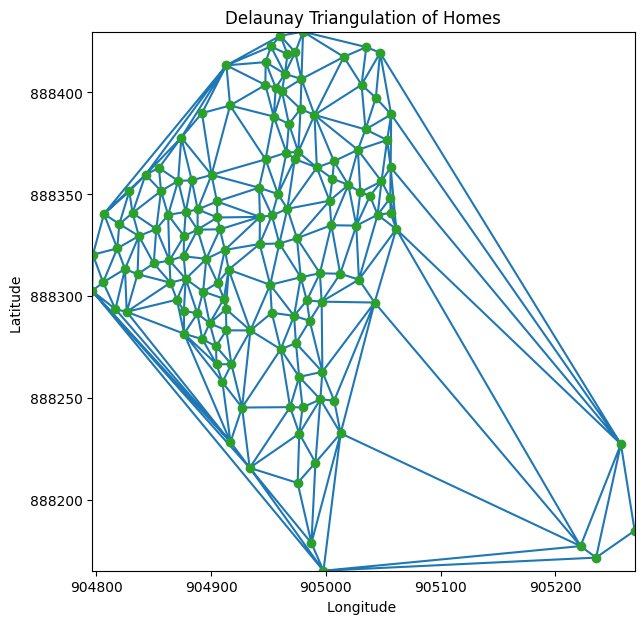

In [15]:
xcoords_of_cluster = [x for (x,y) in coords]
ycoords_of_cluster = [y for (x,y) in coords]

# Plot Delaunay triangulation
plt.figure(figsize=(7, 7))
plt.title('Delaunay Triangulation of Homes')
plt.triplot(xcoords_of_cluster, ycoords_of_cluster, tri.simplices)
plt.xlabel('Longitude ')
plt.ylabel('Latitude ')
plt.plot(xcoords_of_cluster, ycoords_of_cluster, 'o')
axes = plt.gca()
axes.set_xlim([min(xcoords_of_cluster) - 0.001, max(xcoords_of_cluster) + 0.001])
axes.set_ylim([min(ycoords_of_cluster) - 0.001, max(ycoords_of_cluster) + 0.001])

In [16]:
import networkx as nx

print('Creating a graph from this information (edge weight = distance)...')
G = nx.Graph()
for index, row in distances.iterrows():
    G.add_edge(row['source'], row['dest'], weight=row['distance'])

print('Calculating the minimum spanning tree of the graph...')
T = nx.minimum_spanning_tree(G)

edges = T.edges(data=True)
weights = [x[2]['weight'] for x in edges]
total_dist = sum(weights)

print('Number of nodes (buildings) in the graph: ', T.number_of_nodes())
print('Number of edges in the minimum spanning tree: ', T.number_of_edges())
print('Total distance of minimum spanning tree (in km): ', total_dist)


Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  139
Number of edges in the minimum spanning tree:  138
Total distance of minimum spanning tree (in km):  2102.945498522695


In [17]:
for edge in edges:
  print(edge[0],edge[1])


0.0 2.0
0.0 7.0
1.0 3.0
134.0 133.0
131.0 16.0
57.0 13.0
2.0 3.0
7.0 132.0
56.0 55.0
56.0 138.0
49.0 48.0
53.0 52.0
53.0 55.0
4.0 43.0
4.0 104.0
104.0 82.0
44.0 29.0
105.0 43.0
105.0 103.0
65.0 82.0
116.0 42.0
116.0 117.0
5.0 121.0
5.0 61.0
5.0 6.0
121.0 63.0
121.0 10.0
121.0 70.0
10.0 81.0
11.0 6.0
6.0 119.0
64.0 61.0
61.0 130.0
119.0 128.0
16.0 59.0
132.0 8.0
70.0 9.0
60.0 59.0
8.0 9.0
21.0 80.0
135.0 137.0
81.0 22.0
22.0 73.0
120.0 31.0
120.0 100.0
84.0 83.0
12.0 122.0
111.0 112.0
122.0 62.0
13.0 14.0
62.0 24.0
14.0 58.0
18.0 17.0
15.0 17.0
15.0 58.0
59.0 17.0
17.0 130.0
19.0 74.0
19.0 73.0
73.0 83.0
20.0 83.0
20.0 72.0
72.0 45.0
45.0 76.0
45.0 46.0
76.0 75.0
29.0 102.0
79.0 137.0
79.0 50.0
80.0 50.0
23.0 138.0
23.0 48.0
48.0 47.0
89.0 88.0
54.0 78.0
54.0 138.0
24.0 25.0
24.0 129.0
127.0 124.0
25.0 26.0
26.0 128.0
26.0 126.0
126.0 27.0
27.0 125.0
128.0 123.0
125.0 124.0
125.0 28.0
99.0 123.0
99.0 100.0
98.0 33.0
32.0 100.0
102.0 101.0
103.0 30.0
103.0 38.0
33.0 37.0
33.0 34.0
38.0 3

In [18]:
from shapely.geometry import LineString

# Create a geopandas dataframe and save as .shp

# create an array of LineString from T
lines = []
for (i,edge) in enumerate(edges):
  point_a = coords[int(edge[0])]
  point_b = coords[int(edge[1])]
  line = LineString([point_a, point_b])
  lines.append(line)



d = {'geometry':lines}
mstDF = gp.GeoDataFrame(d, crs="EPSG:32628")
mstDF.to_file("sierra_leone.shp")
    
    

Plotting results:


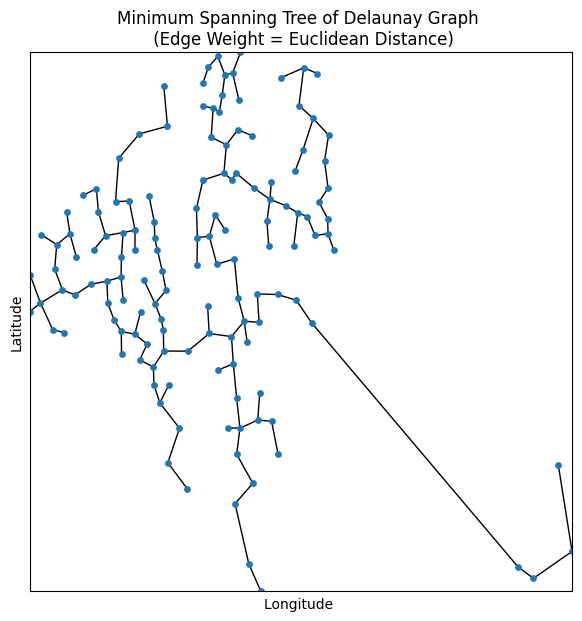

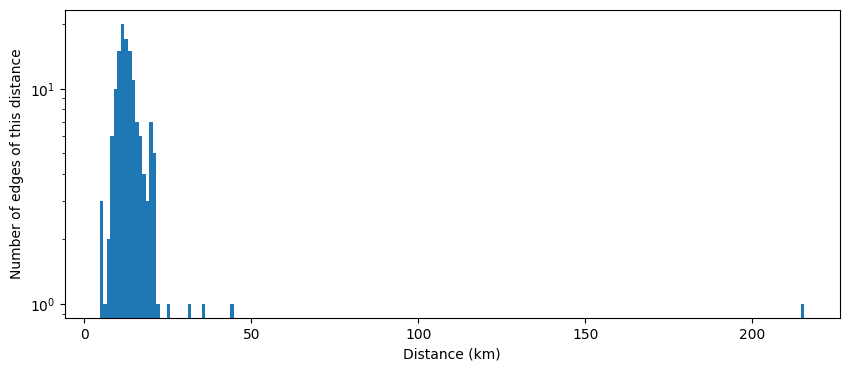

In [19]:
print('Plotting results:')

# Plot Minimum Spanning Tree made from Delaunay Triangulation
plt.figure(figsize=(7, 7))
nx.draw_networkx(T, pos=locations, with_labels=False, node_size=15)
plt.title('Minimum Spanning Tree of Delaunay Graph \n (Edge Weight = Euclidean Distance)')
plt.xlabel('Longitude ')
plt.ylabel('Latitude')
axes = plt.gca()
axes.set_xlim([min(xcoords_of_cluster) - 0.001, max(xcoords_of_cluster) + 0.001])
axes.set_ylim([min(ycoords_of_cluster) - 0.001, max(ycoords_of_cluster) + 0.001])

# Plot relative frequency of edge distances in minimum spanning tree
plt.figure(figsize=(10, 4))
plt.hist(weights, bins=200)
plt.yscale("log")
plt.ylabel('Number of edges of this distance')
plt.xlabel('Distance (km)')

plt.show()
